# DTSA-5510: Unsupervised Learning Final Project
## Canadian Travel Advisory: Classifying Risk Level from Text
### Wei Yu (David) Wang, March 4th 2024

## Gathering Data, Determining the Method of Data Collection, and Provenance of the data

The data will be scrapped from travel.gc.ca/travelling/advisories
The requests module in Python will be used to download individual websites and beautifulsoup will be used to process the HTML files downloaded.

## Identifying an Unsupervised Learning Problem

Travel Advisories are the government's official source and travel advice for destinations around the world. Destinations are assigned risk levels from "Take normal security precautions" to "Avoid All Travel". 

An issue that was identified with these was just how broad the categories are. For example: The United Kingdom, Germany, Denmark, China, Sierre Leone, and Liberia are all classified as "Excercise a High Degree of Caution". However, travellers to these countries should expect much different levels of risk.

This project will attempt to classify the risk level based on the article contents. The methods used will include Non-Negative Matrix Factorization and Vader Sentiment Analysis. A supervised method (Support Vector Classification) will be used to compare differences between unsupervised and supervised methods.

Unsupervised classification methods will also be used to identify underlying patterns in the dataset and to see if additional categories/classifications are appropriate.


In [177]:
# Import files

# General files
import os
import numpy as np 
import pandas as pd 
from scipy.stats import mode
import itertools
import re # Regular expression

# HTML Web Scrapping
import requests
import time
from unidecode import unidecode
from bs4 import BeautifulSoup

# Visualization files
import matplotlib.pyplot as plt
import seaborn as sns

# nltk
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# models and tuning
from gensim.models import Word2Vec
from gensim import utils
import multiprocessing

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Web Scrapping

From the travel.gc.ca/destinations/ website, a chunk of code listing the destinations was copied out and saved as a text file. The articles for each individual destination was then downloaded using the Requests module in Python. Everything is then combined together in a Pandas dataframe.

Skip to EDA start if you do not want to run the webscrapping code to obtain the data. The data has already been saved in an Excel spreadsheet.

In [4]:
# obtaining a list of territories in travel advisory
root_directory = r'C:\Users\David\Downloads\Travel Advisory Unsupervised\data'

# Creating a list of Canadian Travel Advisory Destinations
list_of_geos = []

with open(os.path.join(root_directory, "travel_advisory_countries.txt"), 'r') as file:
    data = file.readlines()

# Iterate through each line
for line in data:
    if '<option value="' in line:
        # Extract the value within double quotes
        start_index = line.find('"') + 1
        end_index = line.find('"', start_index)
        if start_index != -1 and end_index != -1:
            value = line[start_index:end_index]
            list_of_geos.append(value)

# Creates a list of Canadian travel advisory websites for destinations
website_geos = list(map(lambda x: 'https://travel.gc.ca/destinations/' + x, list_of_geos))
website_geos

['https://travel.gc.ca/destinations/afghanistan',
 'https://travel.gc.ca/destinations/albania',
 'https://travel.gc.ca/destinations/algeria',
 'https://travel.gc.ca/destinations/american-samoa',
 'https://travel.gc.ca/destinations/andorra',
 'https://travel.gc.ca/destinations/angola',
 'https://travel.gc.ca/destinations/anguilla',
 'https://travel.gc.ca/destinations/antarctica',
 'https://travel.gc.ca/destinations/antigua-and-barbuda',
 'https://travel.gc.ca/destinations/argentina',
 'https://travel.gc.ca/destinations/armenia',
 'https://travel.gc.ca/destinations/aruba',
 'https://travel.gc.ca/destinations/australia',
 'https://travel.gc.ca/destinations/austria',
 'https://travel.gc.ca/destinations/azerbaijan',
 'https://travel.gc.ca/destinations/azores',
 'https://travel.gc.ca/destinations/bahamas',
 'https://travel.gc.ca/destinations/bahrain',
 'https://travel.gc.ca/destinations/bangladesh',
 'https://travel.gc.ca/destinations/barbados',
 'https://travel.gc.ca/destinations/belarus',


In [4]:
# Specify the download folder
download_folder = root_directory  
if not os.path.exists(download_folder):
    os.makedirs(download_folder)

# Iterate through each website and download its HTML content
for url in website_geos:
    response = requests.get(url)
    if response.status_code == 200:  # Check if the request was successful
        html_content = response.text
        # Save the HTML content to a file in the specified download folder
        file_path = os.path.join(download_folder, f"{url.split('/')[-1]}.html")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(html_content)
        print(f"Downloaded HTML from {url} to {file_path}")
    else:
        print(f"Failed to download HTML from {url}. Status code: {response.status_code}")
    # Delay for 5 seconds so my connection does not get forcibly closed by the remote host
    time.sleep(5)

Downloaded HTML from https://travel.gc.ca/destinations/afghanistan to C:\Users\David\Downloads\Travel Advisory Unsupervised\data\afghanistan.html
Downloaded HTML from https://travel.gc.ca/destinations/albania to C:\Users\David\Downloads\Travel Advisory Unsupervised\data\albania.html
Downloaded HTML from https://travel.gc.ca/destinations/algeria to C:\Users\David\Downloads\Travel Advisory Unsupervised\data\algeria.html
Downloaded HTML from https://travel.gc.ca/destinations/american-samoa to C:\Users\David\Downloads\Travel Advisory Unsupervised\data\american-samoa.html
Downloaded HTML from https://travel.gc.ca/destinations/andorra to C:\Users\David\Downloads\Travel Advisory Unsupervised\data\andorra.html
Downloaded HTML from https://travel.gc.ca/destinations/angola to C:\Users\David\Downloads\Travel Advisory Unsupervised\data\angola.html
Downloaded HTML from https://travel.gc.ca/destinations/anguilla to C:\Users\David\Downloads\Travel Advisory Unsupervised\data\anguilla.html
Downloaded H

In [6]:
# Mining text from the travel advisory

def extract_text_from_html(html_file_path):
    """
    Input: Html file
    Output: String of words in the travel advisory
    Function: Get the article which is between "Need help" at the beginning and end
    """
    with open(html_file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()

    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Extract text from HTML and remove newlines and backslashes
    text = soup.get_text(separator=' ', strip=True).replace('\n', '')
    return text

def remove_formatting(text):
    """
    Remove all formatting such as newlines, tabs, and slashes from a string.
    """
    # Characters to remove
    characters_to_remove = ['\n', '\r', '\t', '\\', '/']
    # Replace unwanted characters with an empty string
    for char in characters_to_remove:
        text = text.replace(char, ' ')
    return text

def extract_text_between_strings(long_string):
    """
    Extract text between "Risk Level" and "Back to top Need help?" from a long string.
    """
    # Define the regular expression pattern to match the text between "Risk Level" and "Back to top Need help?"
    pattern = r'climate Need help?(.*?)Back to top Need help?'

    # Use re.findall() to find all occurrences of the pattern
    matches = re.findall(pattern, long_string, re.DOTALL)

    # Join the matches together into a single string
    extracted_text = ' '.join(matches)

    return extracted_text.strip()

In [7]:
# Creating a list of destination articles

destination_articles = []
risk_level = []

for d in list_of_geos:
    html_file_path = os.path.join(download_folder, f"{d.split('/')[-1]}.html")
    raw_text = extract_text_from_html(html_file_path)
    formatted_article = remove_formatting(raw_text)
    extracted_text = extract_text_between_strings(formatted_article)
    extracted_text = extracted_text.lower()
    destination_articles.append(extracted_text)
    beginning = extracted_text[2: 200]
    if 'exercise a high degree of caution' in beginning:
        risk_level.append('exercise a high degree of caution')
    elif 'take normal security precautions' in beginning:
        risk_level.append('take normal security precautions')
    elif 'avoid all travel' in beginning:
        risk_level.append('avoid all travel')
    elif 'avoid non-essential travel' in beginning:
        risk_level.append('avoid non-essential travel')
    else:
        risk_level.append('Error')

In [8]:
# Creating the dataframe

df = pd.DataFrame({
    'Destination': list_of_geos,
    'Article': destination_articles,
    'Risk': risk_level,
})

df.to_excel(os.path.join(root_directory, "Canadian_Travel_Advisories.xlsx"), index = False)

# Exploratory Data Analysis: Inspecting, Visualizing, and Cleaning the Data

## Factors, Correlation, Transformation, Outliers, Importance of Specific Factors

### Factors
The factors or components that make up the dataset include the destination name which will act as the index. The article factor will contain the text of the travel advisory. The risk factor will contain the labelled risk value from the Canadian government. 

From the pie chart, it can be seen that 44.8% of destinations are assigned to take normal security precautions, 42.2% to exercise a high degree of caution, 3.5% to avoid non-essential travel, and 9.6% to avoid all travel. The models created should have an accuraccy greater than 44.8% to be more effective than just predicting the most common risk level.

From the frequency plot it can be seen that the top 50 words are filled with stop words. Data pre-processing is going to be required. After data pre-processing, it can be seen that the count of the most frequent words dropped significantly with the removal of stop words. 

In [139]:
# Start from here to skip data mining steps

df = pd.read_excel(os.path.join(root_directory, "Canadian_Travel_Advisories.xlsx"))

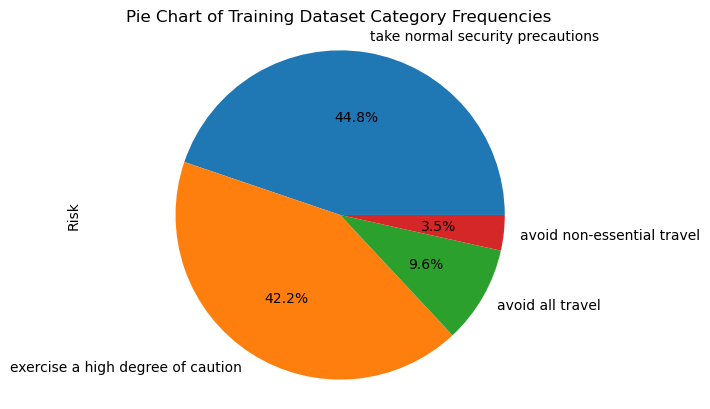

In [140]:
# Plotting a pie chart of the 'Values' column
# Calculate frequency of each term in the 'Category' column
term_freq = df['Risk'].value_counts()

# Plotting a pie chart of term frequencies
term_freq.plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Optional: Add a title
plt.title('Pie Chart of Training Dataset Category Frequencies')

plt.show()

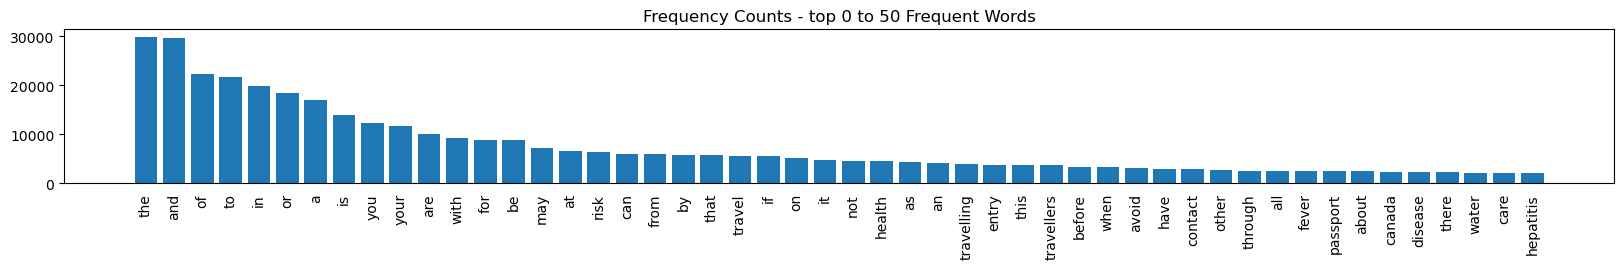

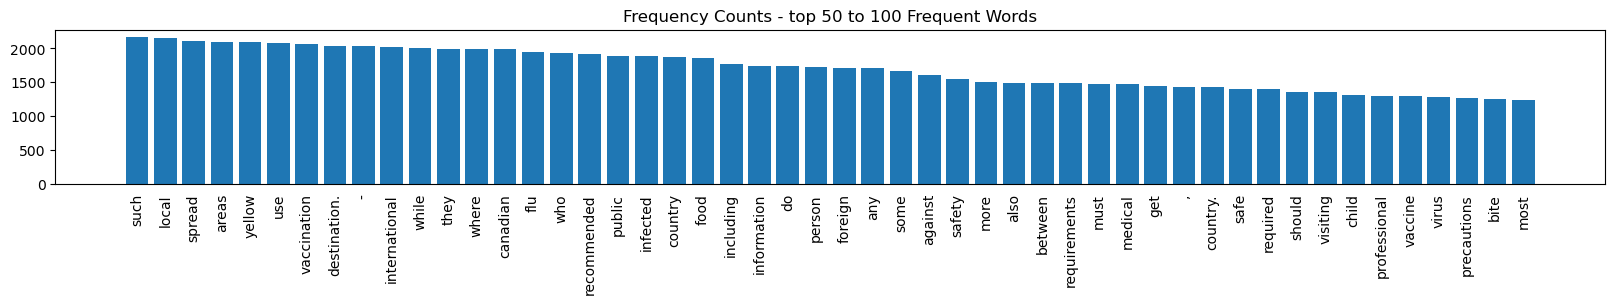

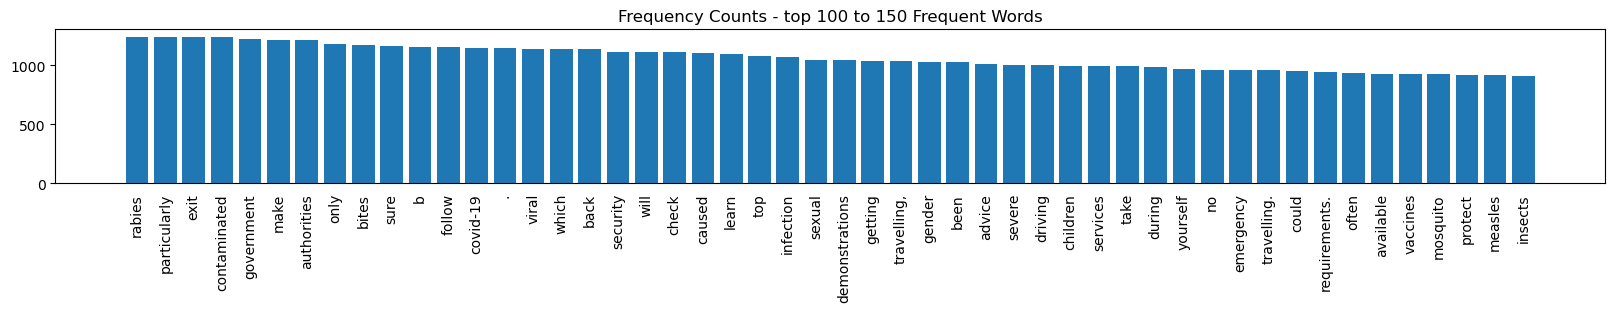

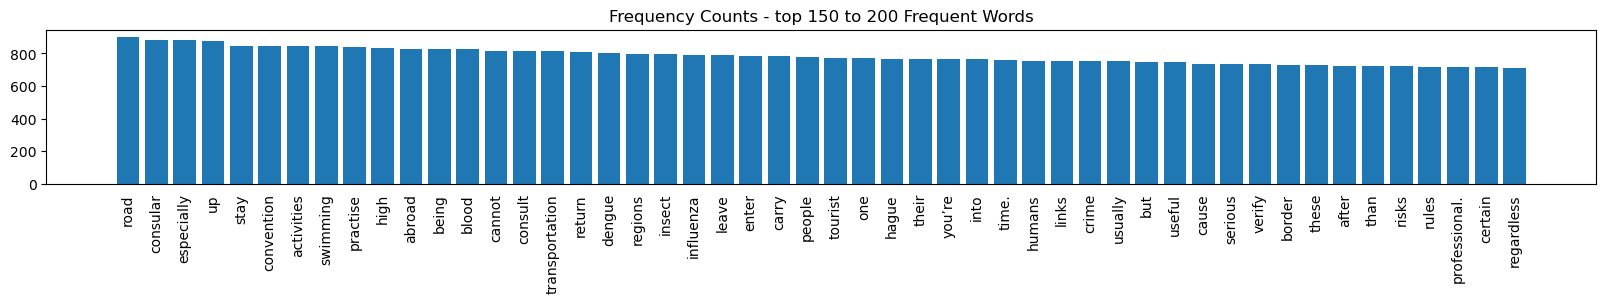

In [141]:
# plot some most frequent words
def frequency_plot(frequency,start,end):
    frequency = frequency[start:end]
    plt.figure(figsize=(20,2))
    plt.bar(frequency.index, frequency)
    plt.title(f'Frequency Counts - top {start} to {end} Frequent Words')
    plt.xticks(ticks=frequency.index,rotation=90, labels=frequency.index)
    plt.tick_params(axis='x', which='both', bottom=False, top=False)
    plt.show()

frequency = df['Article'].str.split().explode().value_counts()

frequency_plot(frequency,0,50)
frequency_plot(frequency, 50,100)
frequency_plot(frequency, 100, 150)
frequency_plot(frequency, 150, 200)

In [142]:
# function for text preprocessing

def text_preprocessing(df):
    """
    This function does in place replacement of data so it won't return anything
    """
    # convert to lower cases
    df['Article']=df['Article'].str.lower()

    # remove punctuation
    df['Article'] = df['Article'].apply(lambda doc: re.sub(r'[^\w\s]+', '', doc))
    # remove extra spaces
    df['Article'] = df['Article'].apply(lambda doc: re.sub(' +', ' ', doc))
 
    # stemming
    snowball_stemmer = SnowballStemmer("english", ignore_stopwords = False)
    df['Article'] = df['Article'].apply(lambda doc:  [snowball_stemmer.stem(word) for word in word_tokenize(doc) ])
    df['Article'] = df['Article'].apply(lambda words: ' '.join(words))

An anticipated issue is that stop words should not be removed. This increases dimensionality but keeps context for words such as "No". It is likely that the more times "No" appears, the higher the risk level.

In [143]:
# text preprocessing

df_copy = df.copy()
text_preprocessing(df_copy)
frequency = df_copy['Article'].str.split().explode().value_counts()

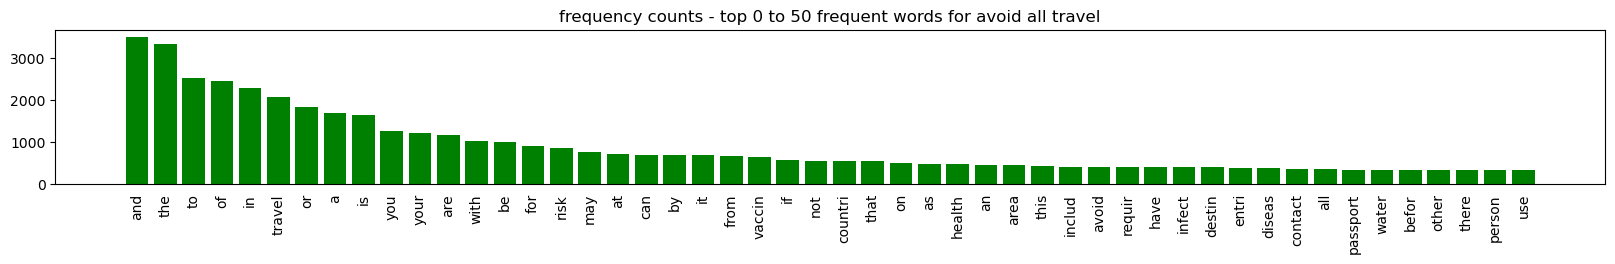

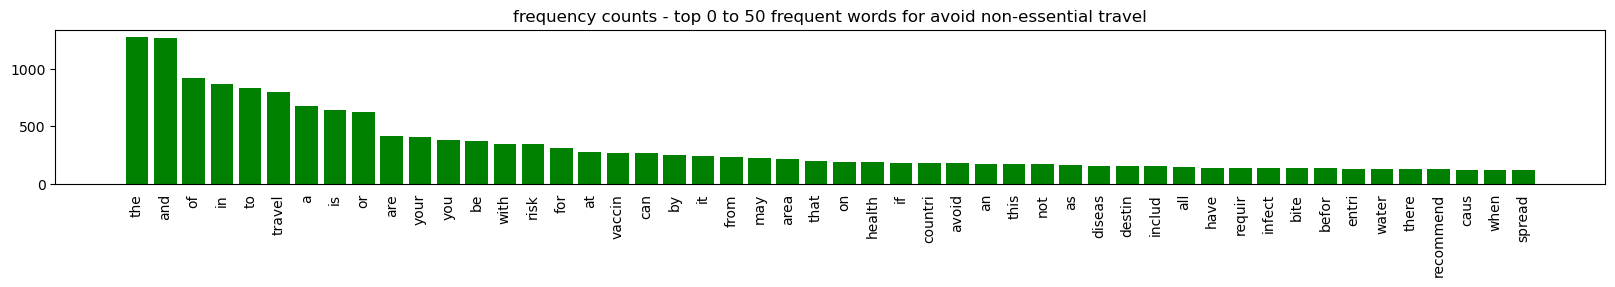

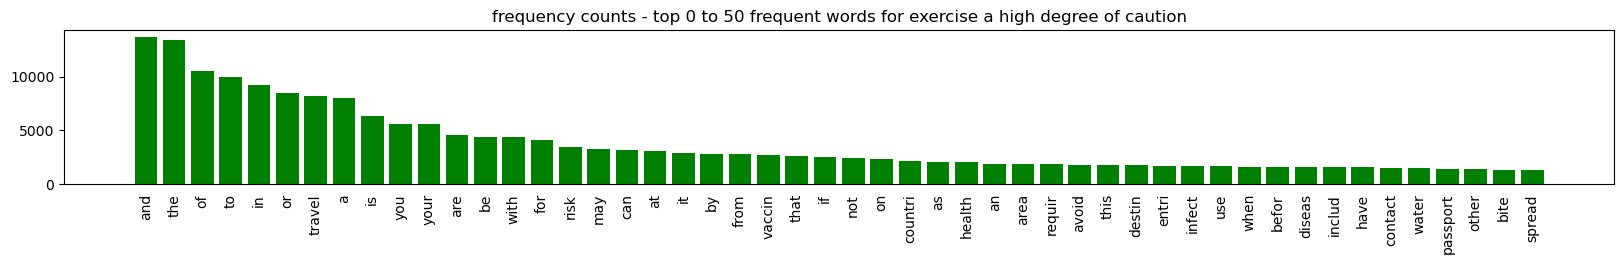

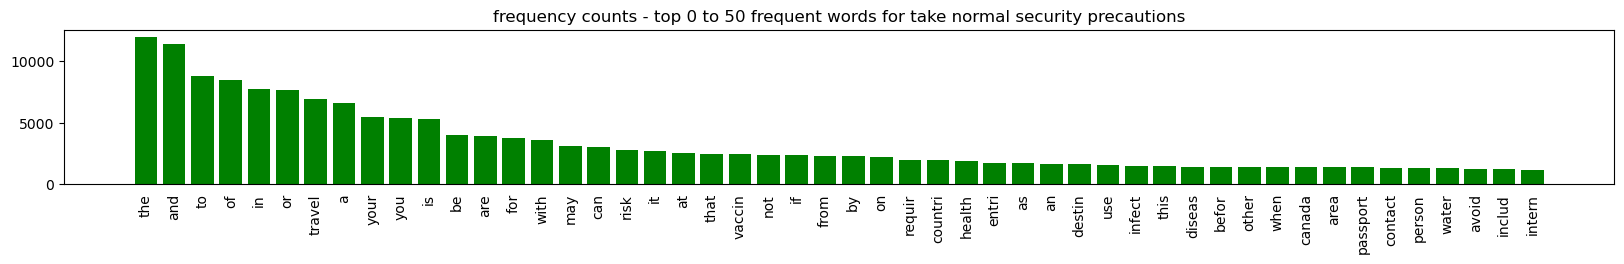

In [144]:
# plot top 50 frequent words in each category after some word preprocessing
def frequency_plot(df ,start,end, Category):
    df_topic=df[df['Risk']== Category] 
    frequency = df_topic['Article'].str.split().explode().value_counts()
    
    frequency = frequency[start:end]
    plt.figure(figsize=(20,2))
    plt.bar(frequency.index, frequency, color = 'green')
    plt.title(f'frequency counts - top {start} to {end} frequent words for {Category}')
    plt.xticks(ticks=frequency.index,rotation=90, labels=frequency.index)
    plt.tick_params(axis='x', which='both', bottom=False, top=False)
    plt.show()

frequency_plot(df_copy,0,50,'avoid all travel')
frequency_plot(df_copy,0,50,'avoid non-essential travel')
frequency_plot(df_copy,0,50,'exercise a high degree of caution')
frequency_plot(df_copy,0,50,'take normal security precautions')

### Correlation

For text analysis, a way to measure document similarity is using t-SNE, which stands for t-distributed Stochastic Neighbor Embedding. From the resulting plot, it can be seen that the travel advisories are somewhat similar to one another and it would be difficult to classify into distinct categories of risk. However, a baseline Word2Vec model with a logistic regression labeller can achieve an accuracy of 69.56%

In [145]:
# Word2Vec into Logistic Regression

data = pd.read_excel(os.path.join(root_directory, "Canadian_Travel_Advisories.xlsx"))

# Train the Word2Vec model
tokenized_data = [utils.simple_preprocess(text) for text in data['Article']]
model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, workers=4)

# Function to calculate document embeddings by averaging word embeddings
def document_embedding(doc_text, model):
    words = utils.simple_preprocess(doc_text)
    word_embeddings = [model.wv[word] for word in words if word in model.wv]
    if len(word_embeddings) > 0:
        return np.mean(word_embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Calculate document embeddings for each string in the labeled column
data['document_embedding'] = data['Article'].apply(lambda x: document_embedding(x, model))

# Split the data for training a classifier
X_train, X_test, y_train, y_test = train_test_split(data['document_embedding'].tolist(),
                                                    data['Risk'], test_size=0.5, random_state=42)

# Train a classifier (e.g., Logistic Regression) to predict labels based on document embeddings
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Evaluate the classifier
accuracy = classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.6869565217391305


In [146]:
# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Calculate classification metrics
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
                                    precision    recall  f1-score   support

                 avoid all travel       0.00      0.00      0.00        12
       avoid non-essential travel       0.00      0.00      0.00         5
exercise a high degree of caution       0.63      0.71      0.67        51
 take normal security precautions       0.74      0.91      0.82        47

                         accuracy                           0.69       115
                        macro avg       0.34      0.41      0.37       115
                     weighted avg       0.58      0.69      0.63       115



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


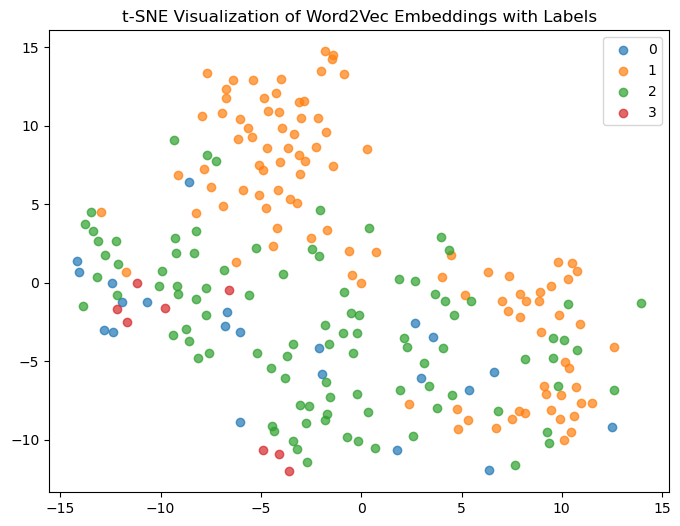

In [147]:
# Convert labels to numeric form3

# Mapping from text labels to numerical labels
label_mapping = {'take normal security precautions': 1, 'exercise a high degree of caution': 2,
                'avoid non-essential travel' : 3, 'avoid all travel' : 4}

# Convert text labels to numerical labels
data['predicted_numerical'] = data['Risk'].map(label_mapping)

label_mapping = {label: i for i, label in enumerate(data['predicted_numerical'].unique())}
data['label_numeric'] = data['predicted_numerical'].map(label_mapping)

# Extract Word2Vec embeddings and labels
embeddings = np.array(data['document_embedding'].tolist())
labels = np.array(data['label_numeric'])

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the t-SNE visualization
plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label, alpha=0.7)
plt.title('t-SNE Visualization of Word2Vec Embeddings with Labels')
plt.legend()
plt.show()

### Transformation

There is no need to transform the data. The inputs are all text based and it will be difficult to normalize or scale factors. One potential way is to 

According to my hypothesis it is unlikely I should transform my data. For Non Negative Matrix Factoriaztion, a TF-IDF vectorizer is used to convert text into numerical values.

### Outliers

From domain knowledge, I know that there are outliers and I want to see which method best deal with them. There are regional advisories for many destinations located within the text. For example, Mexico is at "Exercise a high degree of caution" but there is a regional risk of "Avoid all travel" to Guerrero, and "Avoid non-essential travel" to 11 Mexican States. 

There are only 230 destinations and 60 of them have regional advisories. I am including the regional advisory risk level with the country's general risk level because some categories are too small (only Burkina Faso is Avoid all travel with regional advisories.

### Intuition

One of the benefits of unsupervised machine learning is the possibility to see just how much a prediction is off and underlying patterns in the data. This will be explored in the analysis.


# Analysis
## VADER Sentiment Analysis, Word2Vec and KMeans, and Comparison with Supervised Classification

### VADER Sentiment Analysis

This is a controversial choice because this is considered an [unsupervised lexicon-based model.](https://intapi.sciendo.com/pdf/10.2478/acss-2023-0012) 

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a rule-based sentiment analysis tool specifically designed for analyzing sentiments expressed in text. It is included in the NLTK (Natural Language Toolkit) library and is widely used for sentiment analysis tasks in Python.

This is the most promising method for this project's purpose as it does not need labels and outputs an ordinal value allowing for sorting based on modelled risk levels.

In [148]:
# Sentiment Analysis VADER Unsupervised
dfsia_copy = pd.read_excel(os.path.join(root_directory, "Canadian_Travel_Advisories.xlsx"))

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each text
dfsia_copy['sentiment'] = dfsia_copy['Article'].apply(lambda x: sia.polarity_scores(x)['compound'])
dfsia_copy = dfsia_copy.sort_values(by='sentiment', ascending=False)
dfsia_copy = dfsia_copy.reset_index(drop=True)

In [149]:
# Labelled 
term_freq = dfsia_copy['Risk'].value_counts()
term_freq

take normal security precautions     103
exercise a high degree of caution     97
avoid all travel                      22
avoid non-essential travel             8
Name: Risk, dtype: int64

In [150]:
dfsia_copy['SIA_Pred_Risk'] = ''

# Set values for the 'category' column based on the specified pattern
dfsia_copy.loc[:102, 'SIA_Pred_Risk'] = 'take normal security precautions'
dfsia_copy.loc[103:199, 'SIA_Pred_Risk'] = 'exercise a high degree of caution'
dfsia_copy.loc[200:207, 'SIA_Pred_Risk'] = 'avoid non-essential travel'
dfsia_copy.loc[208:, 'SIA_Pred_Risk'] = 'avoid all travel'

In [151]:
# Mapping from text labels to numerical labels
label_mapping = {'take normal security precautions': 1, 'exercise a high degree of caution': 2,
                'avoid non-essential travel' : 3, 'avoid all travel' : 4}

# Convert text labels to numerical labels
dfsia_copy['predicted_numerical'] = dfsia_copy['SIA_Pred_Risk'].map(label_mapping)
dfsia_copy['actual_numerical'] = dfsia_copy['Risk'].map(label_mapping)

# Extract predicted and actual numerical values from DataFrame
predicted_values = dfsia_copy['predicted_numerical']
actual_values = dfsia_copy['actual_numerical']

# Compute accuracy
accuracy = accuracy_score(actual_values, predicted_values)

print("Test accuracy:", accuracy)

Test accuracy: 0.6304347826086957


In [152]:
report = classification_report(actual_values, predicted_values)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           1       0.79      0.79      0.79       103
           2       0.60      0.60      0.60        97
           3       0.00      0.00      0.00         8
           4       0.27      0.27      0.27        22

    accuracy                           0.63       230
   macro avg       0.41      0.41      0.41       230
weighted avg       0.63      0.63      0.63       230



While the accuracy is lower than the supervised word2vec logistic regression classifier, it was able to recall some of the Avoid all travel destinations. Below is the output dataframe. A interesting insight was that only the United States had a slightly positive compound sentiment while the rest were very negative. 

Having the sentiment compound score is helpful in identifying potential subcategories. UK, Maldives, Germany were placed in the same category as Bangladesh, Cambodia, and Togo at "Exercise a high degree of Caution". However with a VADER sentiment analysis score, it can be seen that UK, Maldives, Germany are closer to the safer countries such as Portugal and Norway while Bangladesh, Cambodia, and Togo are at the bottom of the "Exercise a high degree of Caution" category.

In [155]:
# Set options to display all rows and columns
pd.set_option('display.max_rows', None)  # None means unlimited
pd.set_option('display.max_columns', None)

dfsia_copy

,Destination,Article,Risk,sentiment,SIA_Pred_Risk,predicted_numerical,actual_numerical
0,united-states,? risk level united states - take normal secur...,take normal security precautions,0.2273,take normal security precautions,1,1
1,guam,? risk level guam - take normal security preca...,take normal security precautions,-0.9912,take normal security precautions,1,1
2,finland,? risk level finland - take normal security pr...,take normal security precautions,-0.9924,take normal security precautions,1,1
3,iceland,? risk level iceland - take normal security pr...,take normal security precautions,-0.9926,take normal security precautions,1,1
4,saint-pierre-et-miquelon,? risk level saint-pierre-et-miquelon - take n...,take normal security precautions,-0.9948,take normal security precautions,1,1
5,antarctica,? risk level antarctica - exercise a high degr...,exercise a high degree of caution,-0.9955,take normal security precautions,1,2
6,falkland-islands,? risk level falkland islands - take normal se...,take normal security precautions,-0.9961,take normal security precautions,1,1
7,monaco,? risk level monaco - take normal security pre...,take normal security precautions,-0.9961,take normal security precautions,1,1
8,virgin-islands-u-s,? risk level u.s. virgin islands - take normal...,take normal security precautions,-0.9964,take normal security precautions,1,1
9,ireland,? risk level ireland - take normal security pr...,take normal security precautions,-0.9969,take normal security precautions,1,1


I also wanted to see the difference between predicted and actual risk levels. Only 2 countries were misclassified by 3 levels, North Korea and Belarus. These countries are the only destinations classified as avoid all travel that are not described as "volatile security situation" and are not currently in a war/conflict.  

For the countries misclassified as avoid all travel but should be exercise a high degree of caution, only Guyana and South Africa (2/13) did not have regional advisories (area in the country with a different rating). It is likely the sentiment analysis picks up words attributing to regions in the destination and assigning it to the entire country, which is intended. 

In [158]:
dfsia = dfsia_copy.copy()
# Calculate the difference between the two columns
dfsia['difference'] = dfsia['predicted_numerical'] - dfsia['actual_numerical']

# Filter rows where the absolute difference is equal to 2
result_df = dfsia[abs(dfsia['difference']) >= 2]
result_df.shape

(27, 8)

In [159]:
result_df

,Destination,Article,Risk,sentiment,SIA_Pred_Risk,predicted_numerical,actual_numerical,difference
42,belarus,? risk level belarus - avoid all travel avoid ...,avoid all travel,-0.9988,take normal security precautions,1,4,-3
49,north-korea,? risk level north korea - avoid all travel av...,avoid all travel,-0.9989,take normal security precautions,1,4,-3
107,lebanon,? risk level lebanon - avoid all travel avoid ...,avoid all travel,-0.9994,exercise a high degree of caution,2,4,-2
141,burkina-faso,? risk level burkina faso - avoid all travel a...,avoid all travel,-0.9996,exercise a high degree of caution,2,4,-2
156,ukraine,? risk level ukraine - avoid all travel avoid ...,avoid all travel,-0.9997,exercise a high degree of caution,2,4,-2
157,somalia,? risk level somalia - avoid all travel avoid ...,avoid all travel,-0.9997,exercise a high degree of caution,2,4,-2
159,libya,? risk level libya - avoid all travel avoid al...,avoid all travel,-0.9997,exercise a high degree of caution,2,4,-2
167,iraq,? risk level iraq - avoid all travel avoid all...,avoid all travel,-0.9997,exercise a high degree of caution,2,4,-2
168,israel-the-west-bank-and-the-gaza-strip,? risk level israel - avoid non-essential trav...,avoid all travel,-0.9997,exercise a high degree of caution,2,4,-2
174,myanmar,? risk level myanmar - avoid all travel avoid ...,avoid all travel,-0.9997,exercise a high degree of caution,2,4,-2


 ### Word2Vec and KMeans
 
Word2Vec is a popular technique in natural language processing (NLP) for generating word embeddings, which are dense vector representations of words in a continuous vector space. The key idea behind Word2Vec is to learn distributed representations of words based on their context in a large corpus of text data.

K-means clustering is a popular unsupervised machine learning algorithm used for clustering data points into a predetermined number of clusters. The algorithm works as follows:

1)    Initialize cluster centroids randomly.
2)    Assign each data point to the nearest cluster centroid.
3)    Update the cluster centroids by computing the mean of all data points assigned to each cluster.
4)    Repeat steps 2 and 3 until convergence (i.e., until the cluster assignments no longer change or until a maximum number of iterations is reached).

Complementary Usage:

Word2Vec and K-means can complement each other for unsupervised text classification as follows:

1)    Word Embeddings as Features: Word2Vec embeddings can be used to represent each document in a corpus as a vector by averaging or concatenating the embeddings of individual words. These document embeddings capture semantic information about the documents.

2)    Dimensionality Reduction: The dimensionality of document embeddings obtained from Word2Vec can be high. K-means clustering can be used as a dimensionality reduction technique to group similar documents into clusters based on their embeddings.

3)    Cluster Interpretation: After clustering, each cluster represents a group of documents with similar semantic content. By inspecting the documents in each cluster, one can interpret and label the clusters based on the predominant topics or themes present in the documents.

4)    Classification and Labeling: Once clusters are identified, they can be labeled based on the predominant topics or themes represented by the documents within each cluster. This provides a form of unsupervised classification for organizing and understanding large text corpora.

In summary, Word2Vec generates dense vector representations of words, which can be used to represent documents. K-means clustering then groups these document embeddings into clusters, enabling unsupervised classification and organization of text data based on semantic similarity. Together, they provide a powerful approach for unsupervised text classification and clustering.

In [160]:
# loading the dataset
df = pd.read_excel(os.path.join(root_directory, "Canadian_Travel_Advisories.xlsx"))

In [161]:
# Train the Word2Vec model
tokenized_data = [article.split() for article in df['Article']]
model = Word2Vec(sentences=tokenized_data, vector_size=200, window=15, min_count=15, workers=4)

# Function to calculate document embeddings by averaging word embeddings
def document_embedding(doc_text, model):
    words = doc_text.split()
    word_embeddings = [model.wv[word] for word in words if word in model.wv]
    if len(word_embeddings) > 0:
        return np.mean(word_embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Calculate document embeddings for each article in the DataFrame
df['Document_Embedding'] = df['Article'].apply(lambda x: document_embedding(x, model))

# Extract document embeddings
X = np.array(df['Document_Embedding'].tolist())

# Perform K-means clustering
kmeans = KMeans(n_clusters= 4, random_state=42)
kmeans.fit(X)

# Assign cluster labels to each article
df['Cluster_Label'] = kmeans.labels_


In [162]:
def assign_true_labels_to_clusters(data):
    # Dictionary of Clusters Sorted by Most Frequent Occurrences
    frequency = Counter(data['Cluster_Label'])
    sorted_frequency = dict(sorted(frequency.items(), key=lambda item: item[1], reverse=True))
    
    # Get the list of keys from the dictionary
    keys_list = list(sorted_frequency.keys())
    
    # List of items

    # Count the frequency of each item in the column
    frequency_counter = Counter(data['Risk'])

    # Sort the items based on their frequencies
    sorted_items = sorted(frequency_counter.items(), key=lambda x: x[1], reverse=True)

    # Extract the unique items from the sorted list
    unique_items_sorted_by_frequency = [item[0] for item in sorted_items]
    
    # Result Dictionary for Mapping
    result_dict = {key: value for key, value in zip(keys_list, unique_items_sorted_by_frequency)}
    
    # mapping values
    data['predicted_cluster'] = data['Cluster_Label'].map(result_dict)
    return data['predicted_cluster'].to_list()


In [163]:
predicted_values = assign_true_labels_to_clusters(df)
actual_values = df['Risk'].to_list()
report = classification_report(actual_values, predicted_values)
print("Classification Report:\n", report)

Classification Report:
                                    precision    recall  f1-score   support

                 avoid all travel       0.23      0.55      0.32        22
       avoid non-essential travel       0.04      0.25      0.07         8
exercise a high degree of caution       0.27      0.15      0.20        97
 take normal security precautions       0.80      0.54      0.65       103

                         accuracy                           0.37       230
                        macro avg       0.33      0.37      0.31       230
                     weighted avg       0.50      0.37      0.41       230



### Fine Tuning Hyperparameters

In [164]:
def train_word2vec(data, vector_size, window, min_count, workers):
    model = Word2Vec(sentences=data, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    return model

def kmeans_clustering(model, num_clusters):
    X = model.wv.vectors
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    return cluster_labels

def evaluate_accuracy(true_labels, predicted_labels):
    predicted_values = assign_true_labels_to_clusters(data_copy['Cluster_Label'], data_copy['Risk'])
    actual_values = data_copy['Risk']
    report = classification_report(actual_values, predicted_values)
    print("Classification Report:\n", report)


# Define hyperparameters for Word2Vec
vector_size_list = [100, 200, 300, 400, 500]
window_list = [1, 5, 10, 20, 40]
min_count_list = [1, 5, 10, 40, 80]

best_model = None
best_accuracy = 0
best_hyperparameters = []

vector_df = []
window_df = []
min_df = []
#Epoch_df = []
accuracy_df = []
f1_df = []

# Fine-tune hyperparameters for Word2Vec
for vector_size in vector_size_list:
    for window in window_list:
        for min_count in min_count_list:
            print(f"Hyperparameters: vector_size={vector_size}, window={window}, min_count={min_count}")

            data = pd.read_excel(os.path.join(root_directory, "Canadian_Travel_Advisories.xlsx"))
            tokenized_data = [text.split() for text in data['Article']]
            print("Loaded data")

            model = train_word2vec(tokenized_data, vector_size, window, min_count, 4)
            print("Word2Vec model trained")
            
            # Calculate document embeddings for each article in the DataFrame
            data['Document_Embedding'] = data['Article'].apply(lambda x: document_embedding(x, model))

            # Extract document embeddings
            X = np.array(data['Document_Embedding'].tolist())

            # Perform K-means clustering
            kmeans = KMeans(n_clusters= 4, random_state=42)
            kmeans.fit(X)

            # Assign cluster labels to each article
            data['Cluster_Label'] = kmeans.labels_
            
            print("Cluster labels assigned to DataFrame")

            # Example: your function to evaluate accuracy based on label permutations
            predicted_values = assign_true_labels_to_clusters(data)
            actual_values = data['Risk'].to_list()
            accuracy = accuracy_score(actual_values, predicted_values)
            f1 = f1_score(actual_values, predicted_values, average='macro')

            vector_df.append(vector_size)
            window_df.append(window)
            min_df.append(min_count)
            accuracy_df.append(accuracy)
            f1_df.append(f1)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
                best_hyperparameters = [vector_size, window, min_count]

print("Best accuracy:", best_accuracy)
print("Best hyperparameters:", best_hyperparameters)
# Use the best model and hyperparameters for classification
# Here you can further analyze the clusters or use them for classification tasks
print("Best accuracy:", best_accuracy)
print("Best hyperparameters:", best_hyperparameters)

# Example usage of cluster labels
best_cluster_labels = kmeans_clustering(best_model, num_clusters=4)
print("Best cluster labels:", best_cluster_labels)



Hyperparameters: vector_size=100, window=1, min_count=1
Loaded data
Word2Vec model trained
Cluster labels assigned to DataFrame
Hyperparameters: vector_size=100, window=1, min_count=5
Loaded data
Word2Vec model trained
Cluster labels assigned to DataFrame
Hyperparameters: vector_size=100, window=1, min_count=10
Loaded data
Word2Vec model trained
Cluster labels assigned to DataFrame
Hyperparameters: vector_size=100, window=1, min_count=40
Loaded data
Word2Vec model trained
Cluster labels assigned to DataFrame
Hyperparameters: vector_size=100, window=1, min_count=80
Loaded data
Word2Vec model trained
Cluster labels assigned to DataFrame
Hyperparameters: vector_size=100, window=5, min_count=1
Loaded data
Word2Vec model trained
Cluster labels assigned to DataFrame
Hyperparameters: vector_size=100, window=5, min_count=5
Loaded data
Word2Vec model trained
Cluster labels assigned to DataFrame
Hyperparameters: vector_size=100, window=5, min_count=10
Loaded data
Word2Vec model trained
Cluster l

In [165]:
# Dataframe of Model Tuning

# Create DataFrame
tuning_df = pd.DataFrame({'Vector': vector_df,'Window': window_df,'Min Count': min_df,'Accuracy': accuracy_df, 'F1': f1_df})

# Display DataFrame
tuning_df

,Vector,Window,Min Count,Accuracy,F1
0,100,1,1,0.243478,0.179430
1,100,1,5,0.173913,0.150633
2,100,1,10,0.152174,0.125654
3,100,1,40,0.421739,0.315875
4,100,1,80,0.421739,0.316228
5,100,5,1,0.386957,0.326068
6,100,5,5,0.365217,0.302487
7,100,5,10,0.378261,0.320481
8,100,5,40,0.382609,0.317488
9,100,5,80,0.373913,0.309548


From the result of the fine tuning, it can be seen that a more unsupervised machine learning such as Word2vec with KMeans clustering is not effective in classifying similar texts.The accurracy never goes above 45%, indicating similar levels of performance to just predicting the most common risk category. 

## Discussion

VADER sentiment analysis and Word2Vec with KMeans are two distinct approaches to text analysis, each offering unique benefits depending on the task at hand. 

VADER comes with a pre-built sentiment lexicon, assigning polarity scores to words and allowing for quick sentiment analysis without the need for extensive training. It excels in capturing nuanced sentiment expressions, accounting for factors like capitalization, punctuation, and degree modifiers. 

On the other hand, Word2Vec with KMeans leverages semantic relationships between words to identify clusters of very similar text based on meaning. It operates in an unsupervised manner, making it adaptable to various types of text data without the need for labeled examples. This approach offers flexibility and interpretability, with each cluster representing a group of documents that share semantic similarity. It is suitable for tasks where the focus is on understanding the underlying meaning of the text rather than just sentiment analysis. Ultimately, the choice between VADER and Word2Vec with KMeans depends on the specific requirements and objectives of the text classification task, with each method offering its own set of advantages.

Word2Vec with a supervised machine learning method such as Logistic Regression produces the highest level of accuracy but is not able to recall smaller categories.

Both VADER sentiment analysis and Word2Vec with KMeans have their limitations, which should be considered when choosing between them for text classification tasks. VADER sentiment analysis, while effective for capturing sentiment in short texts and social media data, has limitations in handling complex linguistic nuances. It relies heavily on the sentiment lexicon, which may not cover all domains or capture context-specific meanings accurately and may not perform optimally on longer texts or documents with mixed sentiments which was the case for this project. 

On the other hand, Word2Vec with KMeans, while offering flexibility and adaptability, has its own set of limitations. Word2Vec relies on the distributional hypothesis, assuming that words appearing in similar contexts have similar meanings. However, it may fail to capture rare or out-of-vocabulary words effectively, especially in domains with specialized terminology. Additionally, Word2Vec embeddings may not preserve certain semantic relationships accurately, leading to suboptimal clustering results. Furthermore, KMeans clustering requires specifying the number of clusters beforehand, which can be challenging, and it may converge to suboptimal solutions depending on the initialization.

Another limitation of both approaches is their inability to capture domain-specific knowledge or incorporate external knowledge sources effectively. For tasks requiring domain-specific understanding or dealing with specialized terminology, additional preprocessing or domain-specific models may be necessary. Additionally, both approaches may struggle with noisy or ambiguous text data, leading to inaccuracies in classification results.

## Conclusion

This project identified that the most effective way to classify travel advisories and their risk levels is using Sentiment Analysis (VADER). The lessons learnt from this project can be applied to other datasets with very similar use of words/structure and an unbalance of categories. 

Domain knowledge is very important and the lexicon identification aspect of VADER gave it an edge in training and performance. 

A way to improve upon this base is to use Generative Pre-trained Transformer series which is a type of language model based on deep learning and is another case of unsupervised machine learning.